In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

import tensorflow as tf

2023-05-29 21:17:22.635345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 21:17:25.240605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-29 21:17:25.240761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
import bayesflow
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d
from custom_plots import plot_sbc_ecdf_appendix, plot_sbc_ecdf

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
plt.rcParams.update({
    "axes.labelsize" : 24,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize": 24,
    "text.usetex": False,
    "font.family": "serif",
    #"font.serif": ["times"],
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

# Gaussian Mixture

In [4]:
benchmark_name = 'gaussian_mixture'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the gaussian_mixture model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
settings_posterior = {
    'dense_args': dict(units=32, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    'dropout_prob': 0.05
}

settings_likelihood = {
    'dense_args': dict(units=64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    'dropout_prob': 0.05
}


# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=8,
    coupling_settings=settings_posterior
)

inference_net_l = InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=10,
    coupling_settings=settings_likelihood,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior, 
    amortized_likelihood
)

2023-05-29 21:17:30.550383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 21:17:30.563290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 21:17:30.565012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 21:17:30.567214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

# Training

In [6]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=1e-3,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False   
)

INFO:root:Loaded loss history from checkpoints/gaussian_mixture/history_128.pkl.
INFO:root:Networks loaded from checkpoints/gaussian_mixture/ckpt-128
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [22]:
EPOCHS = 128
SIMULATION_BUDGET = 10000
N_VAL = 300
BATCH_SIZE = 64

train_data = trainer.generative_model(SIMULATION_BUDGET)

In [29]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Curves

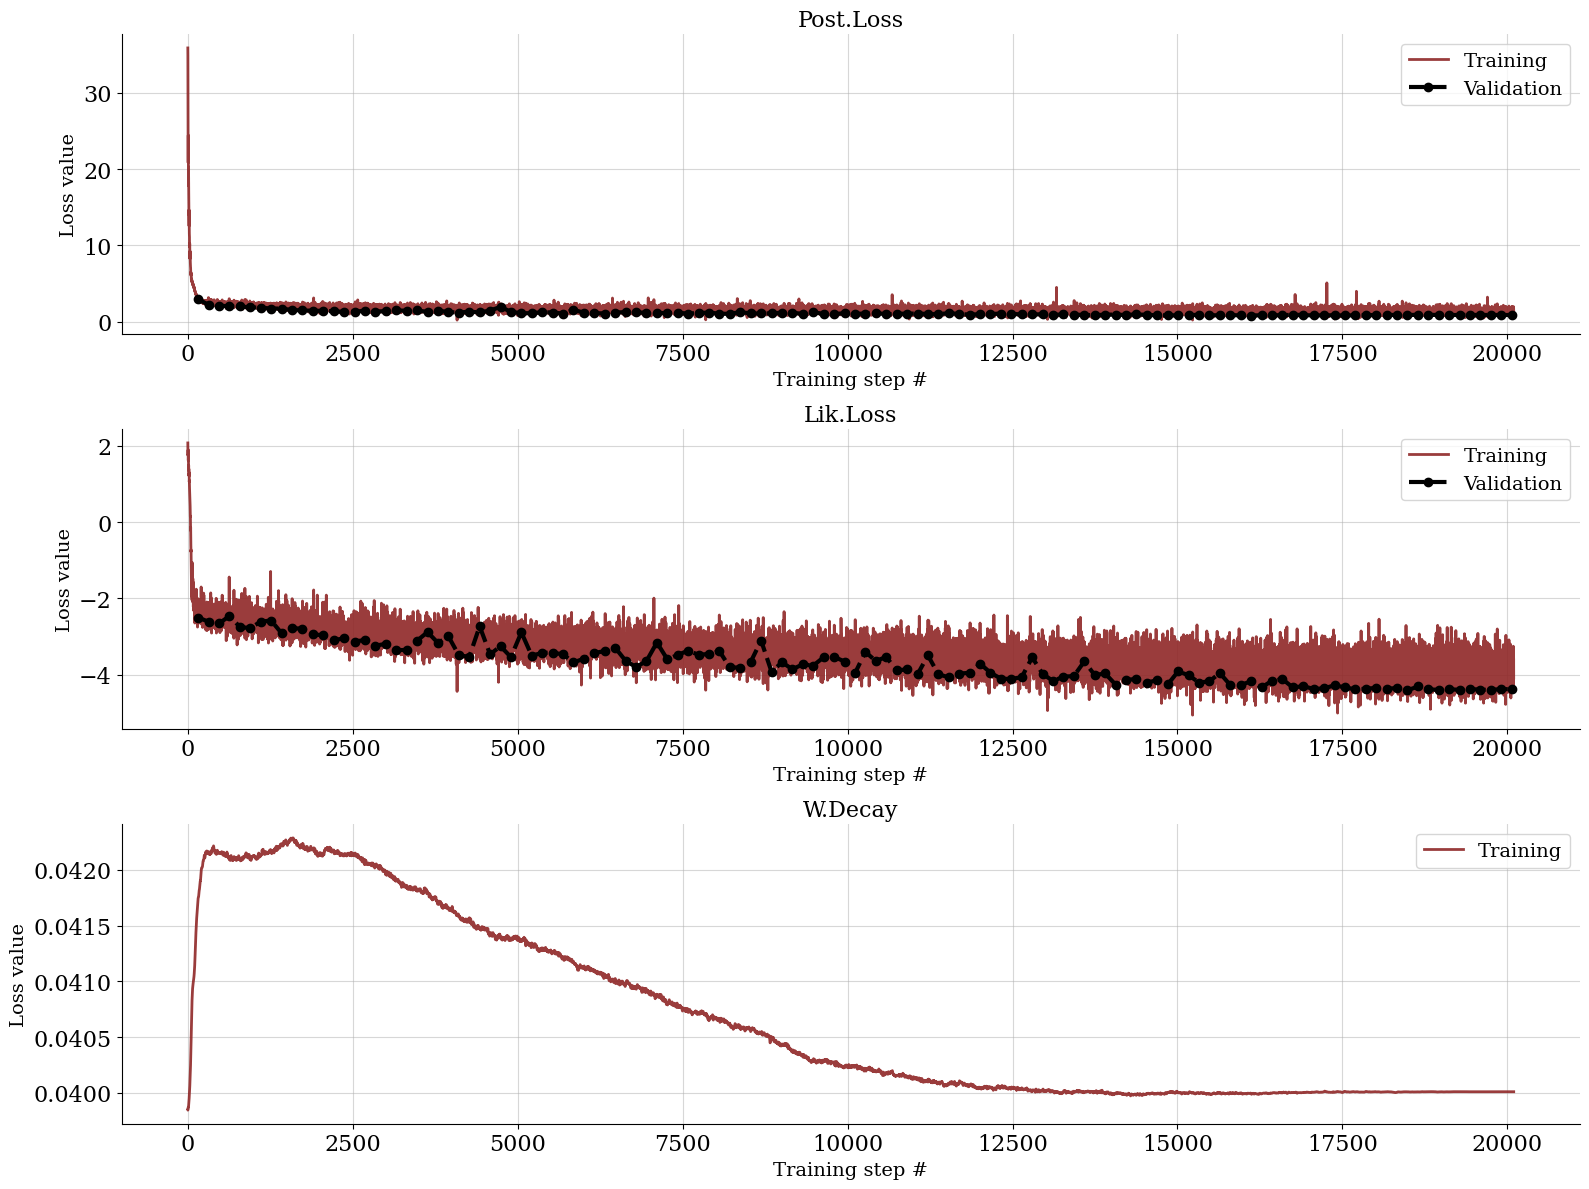

In [7]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test (Held-Out) Data

In [8]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [9]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

### Calibration

#### ECDF Difference (Stacked)

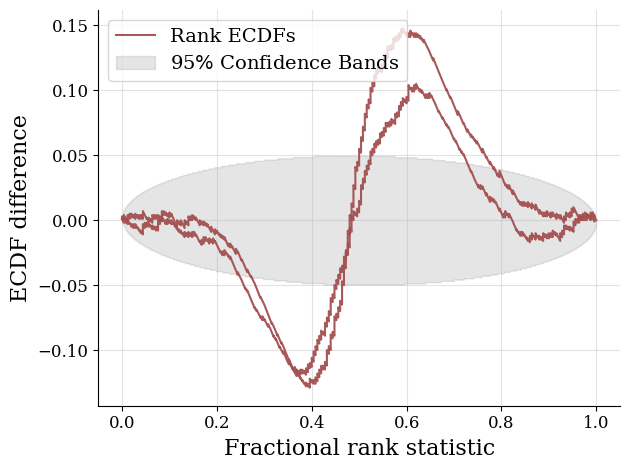

In [10]:
# Posterior given simulator outputs
f = bayesflow.diagnostics.plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, difference=True)

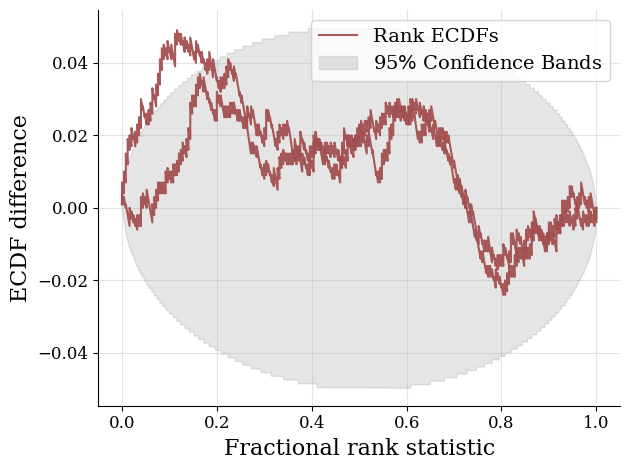

In [11]:
# Posterior given surrogate outputs
f = bayesflow.diagnostics.plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, difference=True)

In [30]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

## Individual Calibration Plots

In [31]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), label_fontsize=24, legend_fontsize=16,
                  difference=True, param_names=[r'$\theta_1$:\,X Location', r'$\theta_2$:\,Y Location'], rank_ecdf_colors=['#000080', '#9999FF'])
f.savefig(f'figures/calibration/{benchmark_name}_diff_ind_post.pdf', dpi=300, bbox_inches='tight')

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../501fbd651395db29fb0a0544dc406079.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 501fbd651395db29fb0a0544dc406079.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fce9402a9e0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../c3259029ad8129cedc83b7203f4a47ee.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on c3259029ad8129cedc83b7203f4a47ee.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../c3259029ad8129cedc83b7203f4a47ee.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on c3259029ad8129cedc83b7203f4a47ee.log.




<Figure size 1000x500 with 2 Axes>

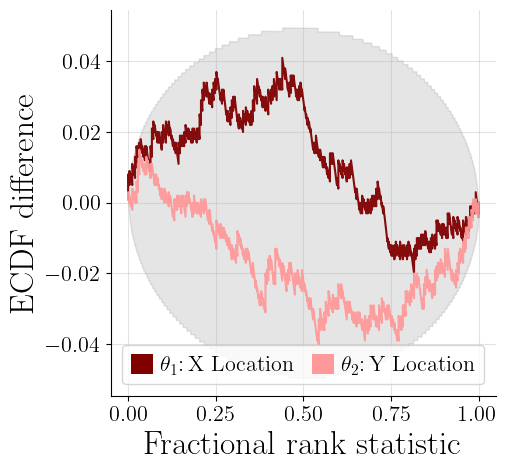

In [24]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), label_fontsize=24, legend_fontsize=16,
                  difference=True, param_names=[r'$\theta_1$:\,X Location', r'$\theta_2$:\,Y Location'], rank_ecdf_colors=['#800000', '#FF9999'])
f.savefig(f'figures/calibration/{benchmark_name}_diff_ind_joint.pdf', dpi=300, bbox_inches='tight')

# Appendix Plots

In [16]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

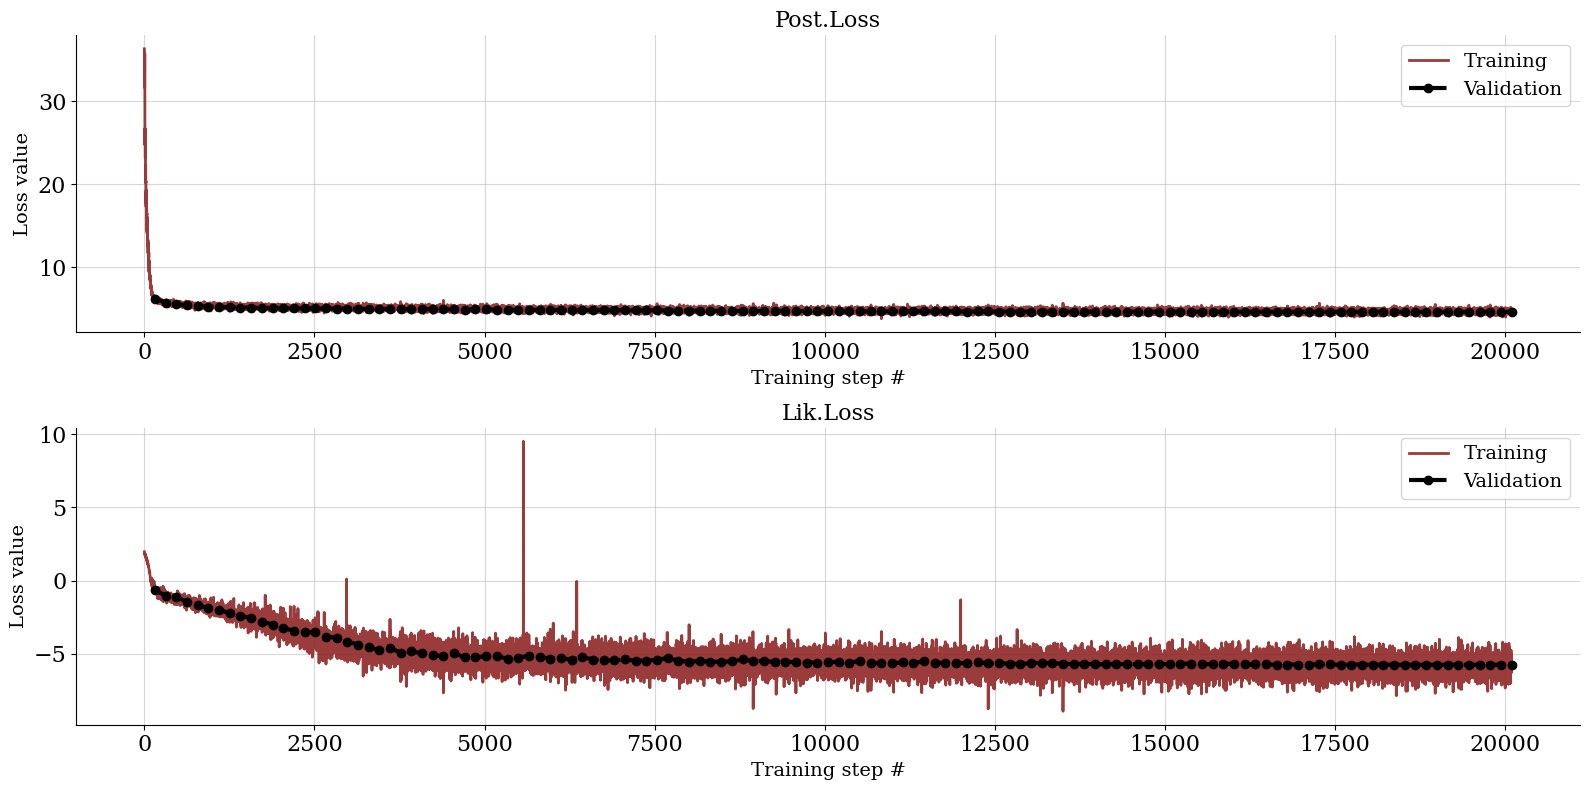

In [17]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

In [32]:
f = plot_sbc_ecdf_appendix(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#000080' )
plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../06e9a50648c7137de9d8cc3a17e9d184.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 06e9a50648c7137de9d8cc3a17e9d184.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fce9402a9e0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../489855e3e8bb32b88d7157b51ad8d86c.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 489855e3e8bb32b88d7157b51ad8d86c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../489855e3e8bb32b88d7157b51ad8d86c.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 489855e3e8bb32b88d7157b51ad8d86c.log.




<Figure size 1000x500 with 2 Axes>

### Joint Calibration

In [33]:
f = plot_sbc_ecdf_appendix(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#800000')
plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../06e9a50648c7137de9d8cc3a17e9d184.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 06e9a50648c7137de9d8cc3a17e9d184.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fce9402a9e0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../489855e3e8bb32b88d7157b51ad8d86c.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 489855e3e8bb32b88d7157b51ad8d86c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2019/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../489855e3e8bb32b88d7157b51ad8d86c.tex
LaTeX2e <2018-12-01>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 489855e3e8bb32b88d7157b51ad8d86c.log.




<Figure size 1000x500 with 2 Axes>